In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp, quad
from scipy import optimize
from IPython.display import display, Latex


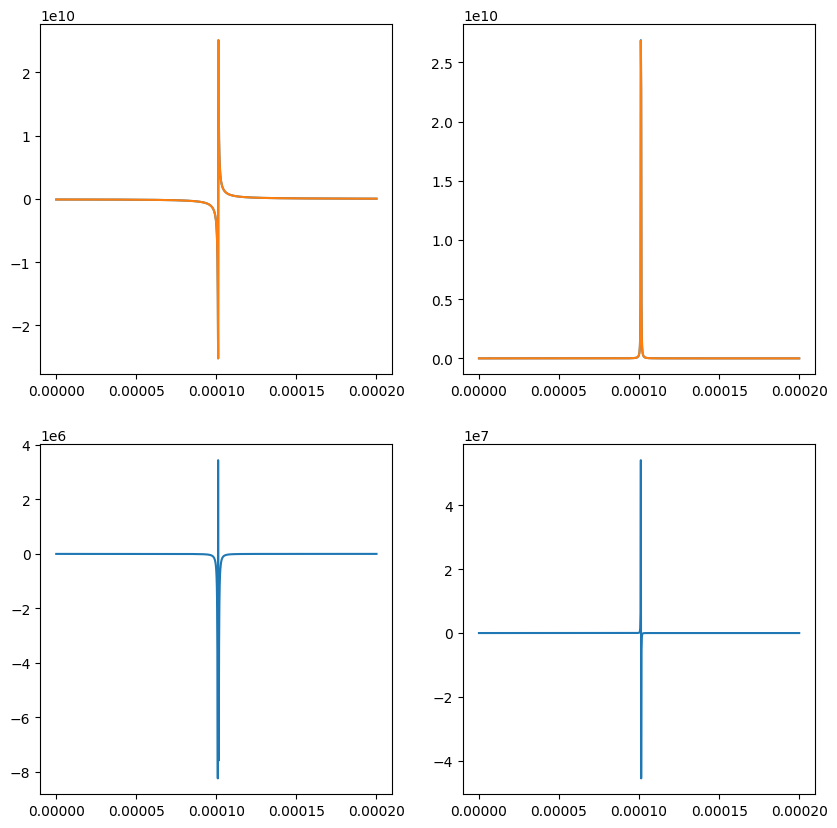

In [15]:
omega_0=2e-4
N=1000
omega=omega_0*np.linspace(0,1,N)
xi=1/(omega**2-2*1j*beta*omega-v**2+v**2*(4*Q*k-1-1j*omega-k**2)/((omega-1j)**2-k**2))

Im_sigma=8*v**2*omega*(Q*k/(k**2+1)**2)
Re_sigma=-v**2*4*Q*k/(1+k**2)
xi_r=1/(omega**2-2*1j*beta*omega-v**2+Re_sigma+1j*Im_sigma)

fig, axs = plt.subplots(2, 2,figsize=(10,10))
axs[0,0].plot(omega,np.real(xi))
axs[0,0].plot(omega,np.real(xi_r))
axs[0,1].plot(omega,np.imag(xi))
axs[0,1].plot(omega,np.imag(xi_r))
axs[1,0].plot(omega,np.real(xi-xi_r))
axs[1,1].plot(omega,np.imag(xi-xi_r))
plt.show()

In [2]:
k=2
Q=1.6*10**5
nu=2e-7
beta=1e-7

def ODE(t,z,beta,nu,Q,k):
    #d=3.2*10**5
    d=1e0
    u,v,xeta,eta=z
    v_dot=nu**2*(2*xeta+xeta**2+eta**2)*d**2/(1+u)-nu**2*u*d**2/(1+u)-2*beta*v*d
    u_dot=v
    xeta_dot=(-(1-(1+u)**0.5)/(1+u)-xeta-k*eta-2*Q*u*eta/(1+u))*d
    eta_dot=(k*(1-(1+u)**0.5)/(1+u)-eta+k*xeta+2*Q*u*(1+xeta)/(1+u))*d

    x_list=[u_dot,v_dot,xeta_dot,eta_dot]
    return x_list
    
def evolve(psi_0,tf,param_list,N_step=100):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t)
    zz=xx.sol(t)
    sol=[]
    sol.append((zz[0]))
    sol.append((zz[1]))
    sol.append((zz[2]))
    sol.append((zz[3]))

    return sol,t
    

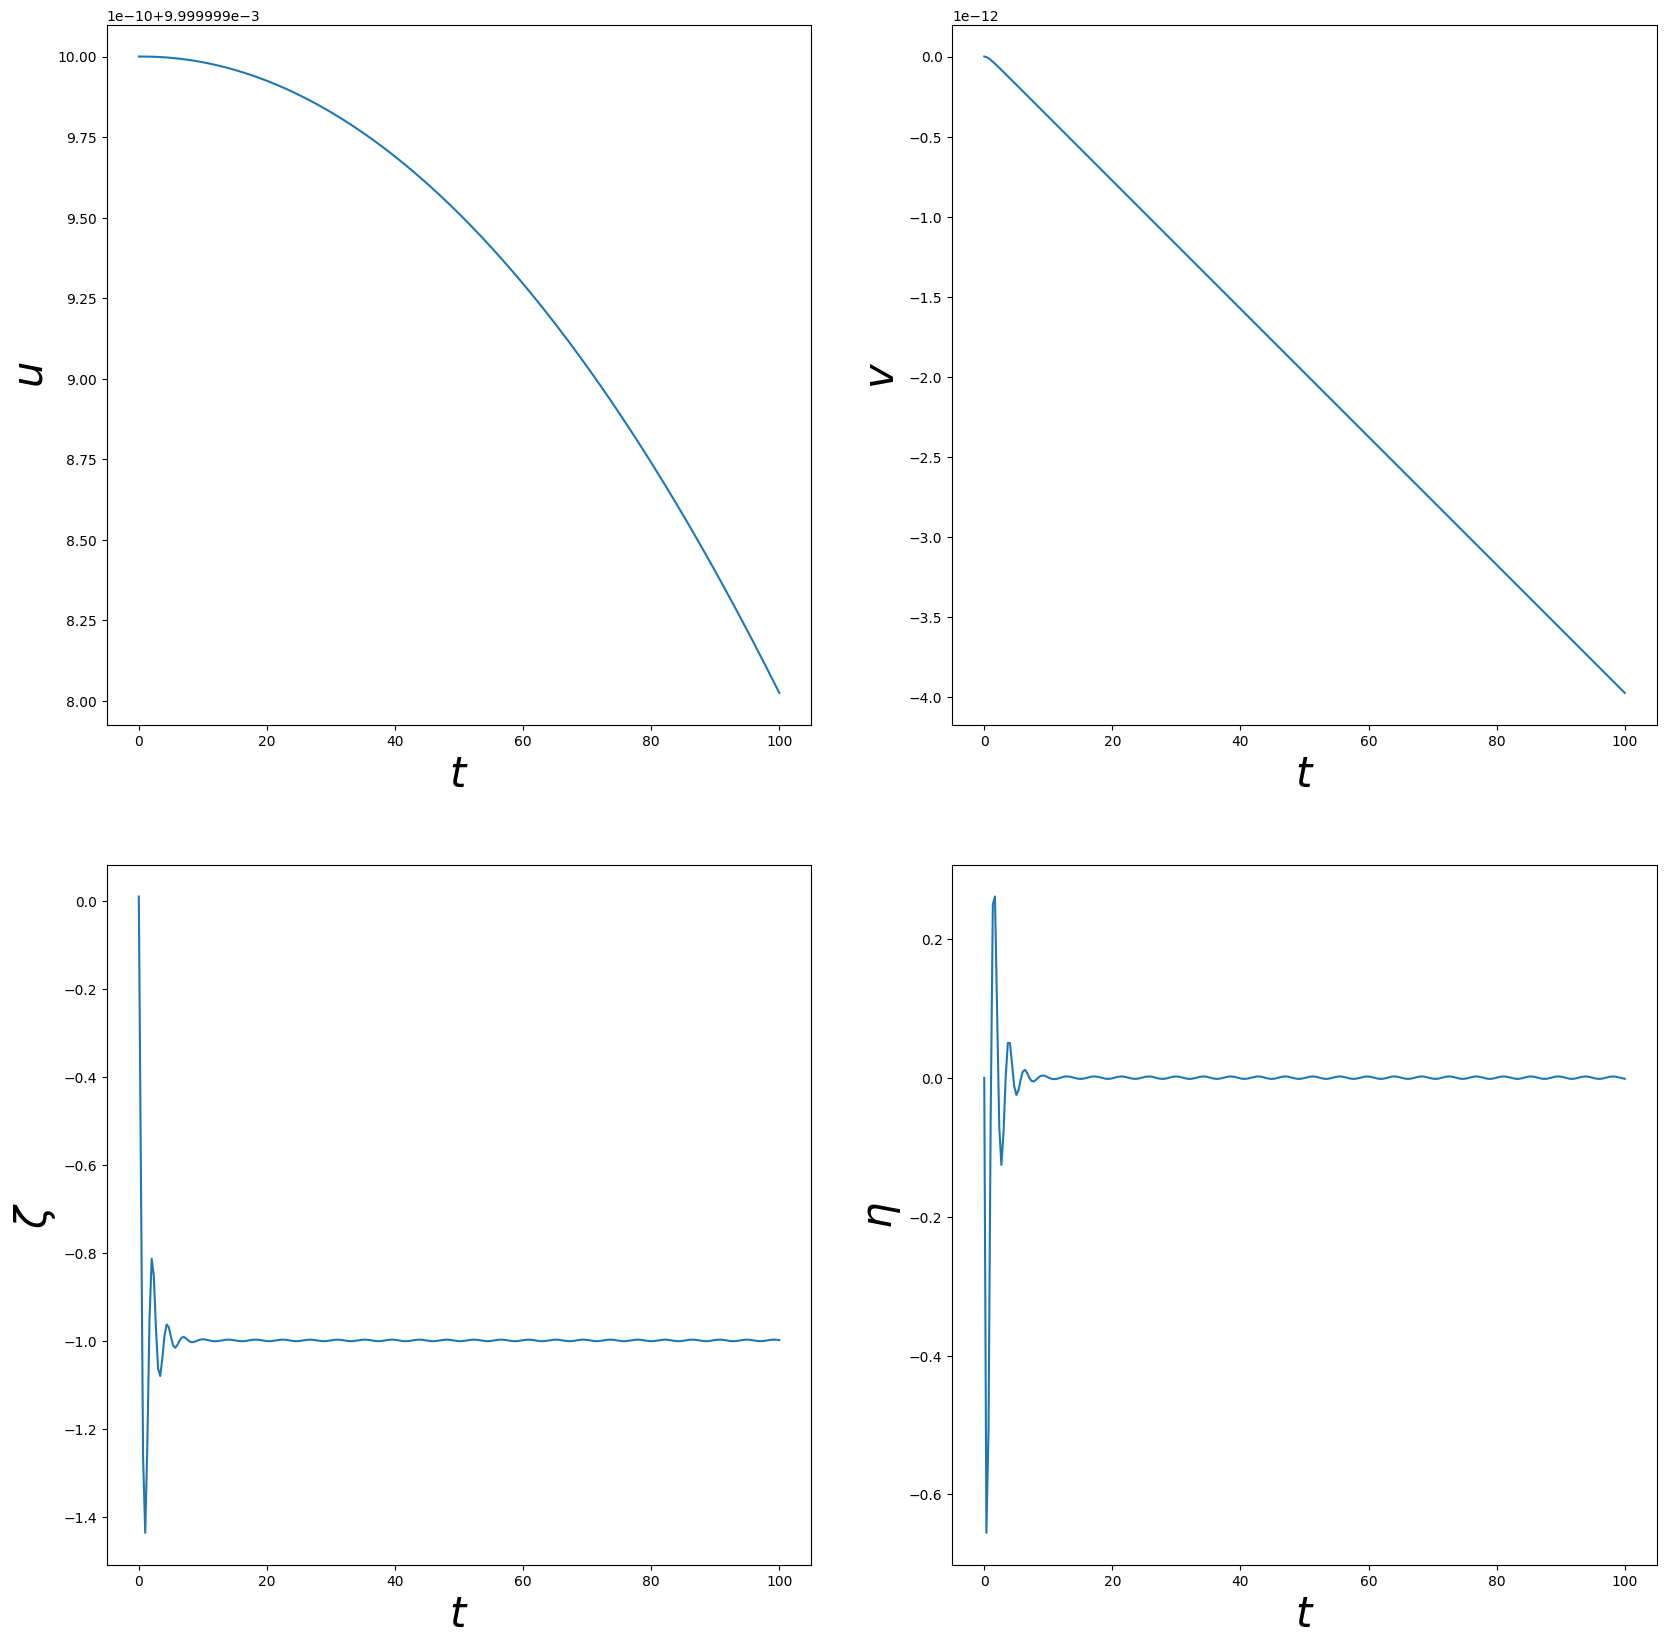

In [25]:
param_list=[beta,nu,Q,k]    
tf=1e2               ### DO NOT increase this by a lot
u_0,v_0,xeta_0,eta_0=1e-2,0,1e-2,0
psi_0=np.array([u_0,v_0,xeta_0,eta_0])
label_list=["$u$","$v$","$\\zeta$","$\\eta$"]

N_step=300
fig, axs = plt.subplots(2, 2,figsize=(20,20))
zz,t=evolve(psi_0,tf,param_list,N_step)
  
for i in range(4):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$t$',fontsize=30)

plt.show() 

In [16]:
lambda_L=1.55*1e-6
F=1e4
xi=np.pi*lambda_L/(2*F)
gamma_m=1e3
g=9.8
eta=(gamma_m/2)*(xi/g)**0.5
eta

0.002492199210420105

In [3]:
w_L=1e9
beta_eq=1e-5
r=1
eta=2e-3

k=2
Q=1.6*10**5
nu=2e-7
beta=1e-7

def ODE(t,z,w_L,beta_eq,r,eta):
    ohm=w_L*beta_eq
    u,v,w,y=z
    #v_dot=nu**2*(2*xeta+xeta**2+eta**2)-nu**2*u-2*beta*v
    v_dot=beta_eq*(2*w+w**2+y**2)-2*beta_eq*u-2*eta*v
    u_dot=v
    #xeta_dot=-(1-(1+u)**0.5)/(1+u)-xeta-k*eta-2*Q*u*eta/(1+u)
    w_dot=0.5*ohm*u-ohm*w-w_L*(beta_eq*r+u)*y
    #eta_dot=k*(1-(1+u)**0.5)/(1+u)-eta+k*xeta+2*Q*u*(1+xeta)/(1+u)
    y_dot=-0.5*r*ohm*u-ohm*y+ohm*(beta_eq*r+u)*w
    x_list=[u_dot,v_dot,w_dot,y_dot]
    return x_list
    
def evolve(psi_0,tf,param_list,N_step=100):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t,method="RK23")
    zz=xx.sol(t)
    sol=[]
    sol.append((zz[0]))
    sol.append((zz[1]))
    sol.append((zz[2]))
    sol.append((zz[3]))
    return sol,t

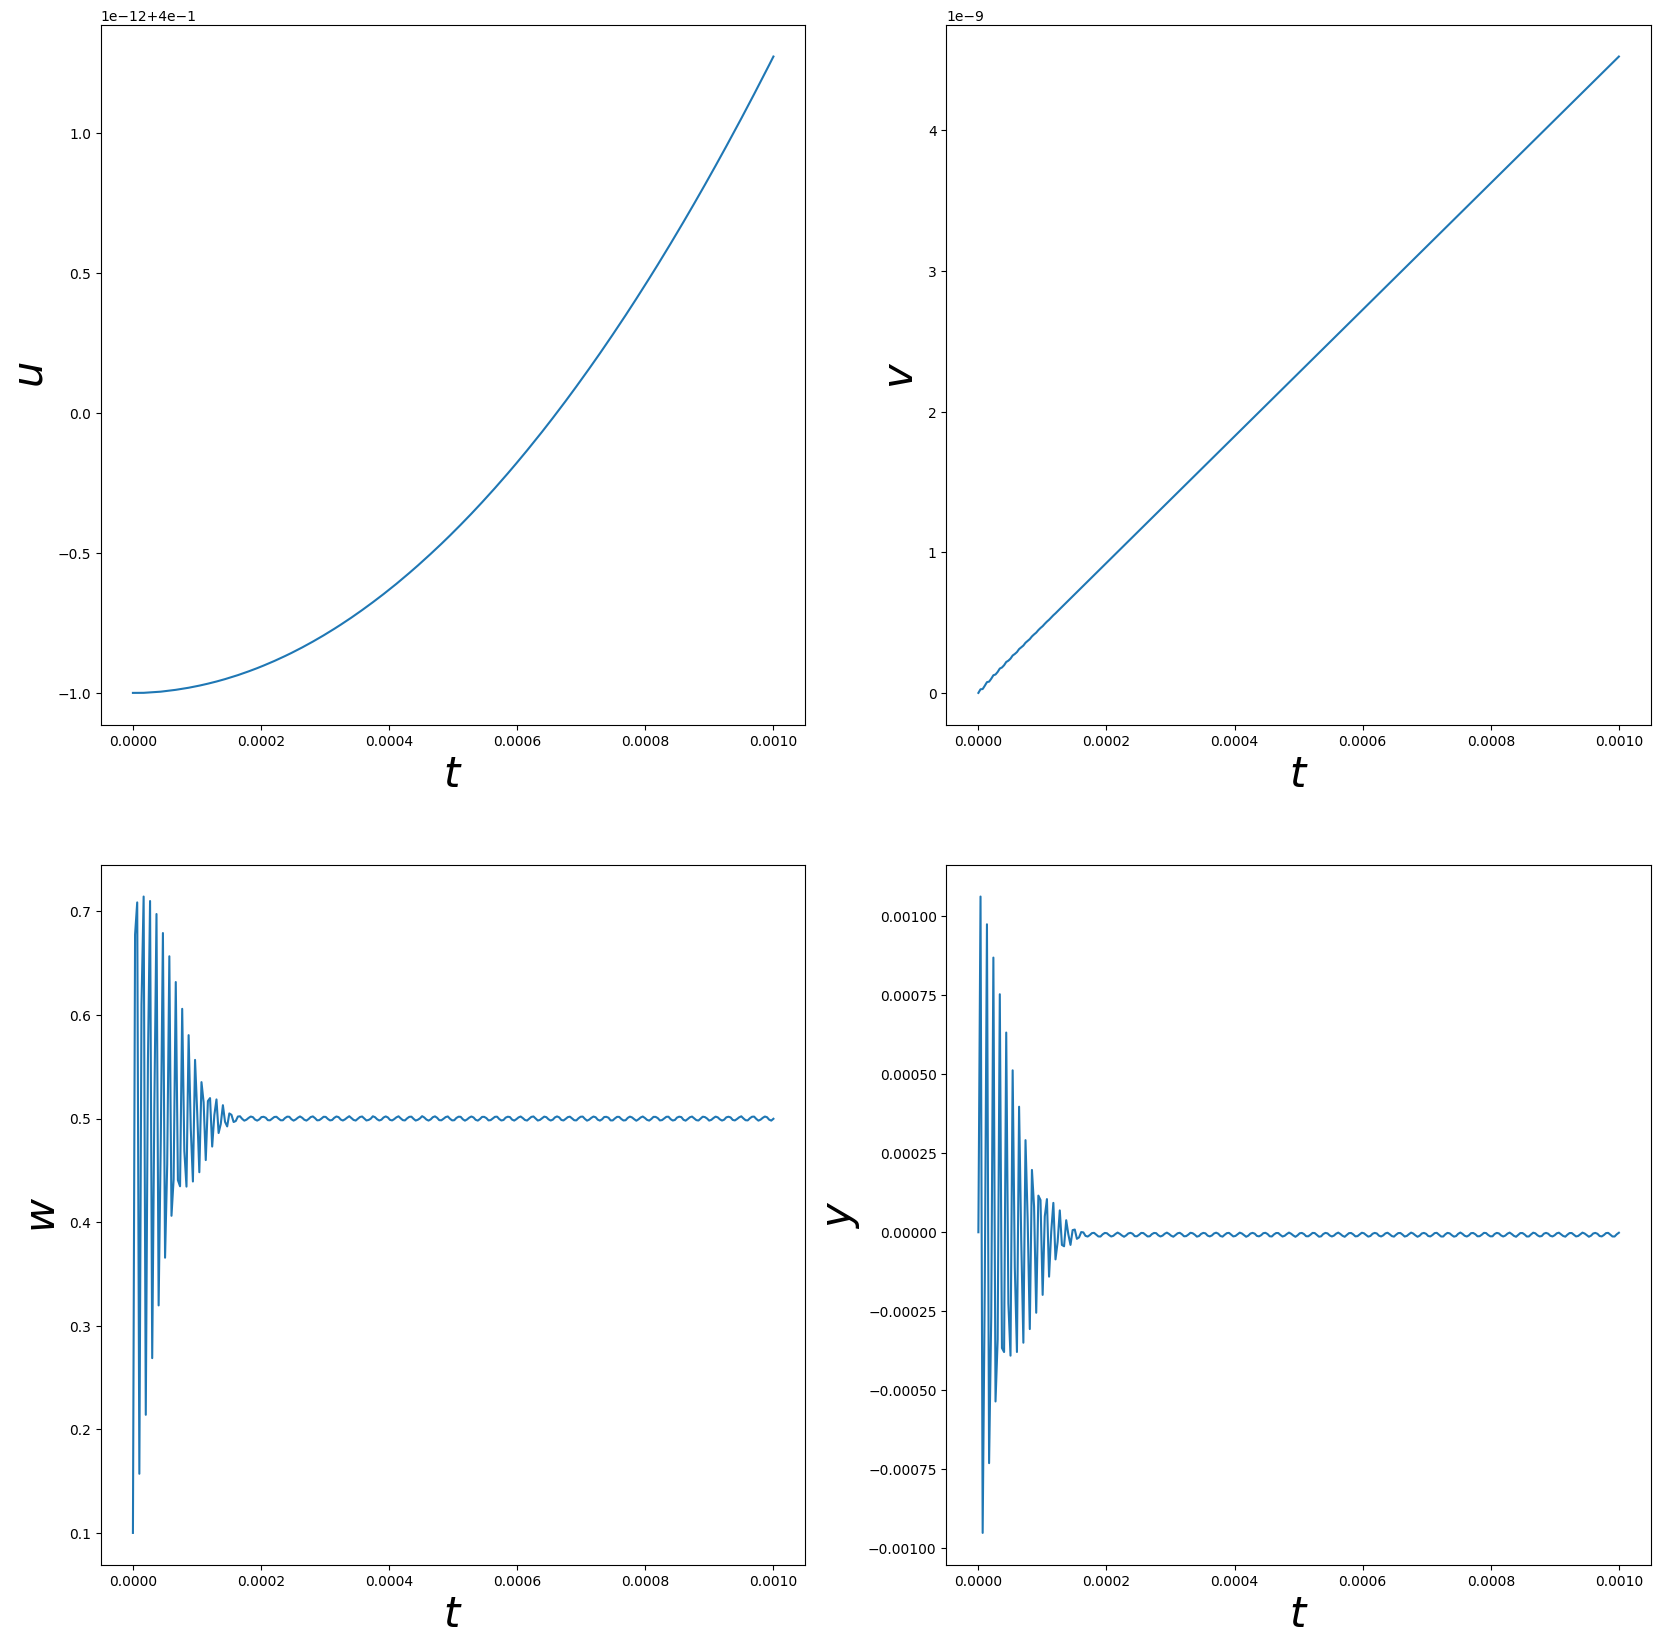

In [67]:
param_list=[w_L,beta_eq,r,eta]    
tf=1e-3               ### DO NOT increase this by a lot
u_0,v_0,w_0,y_0=4e-1,0,1e-1,0
psi_0=np.array([u_0,v_0,w_0,y_0])
label_list=["$u$","$v$","$w$","$y$"]

N_step=300
fig, axs = plt.subplots(2, 2,figsize=(20,20))
zz,t=evolve(psi_0,tf,param_list,N_step)
  
for i in range(4):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$t$',fontsize=30)

plt.show() 

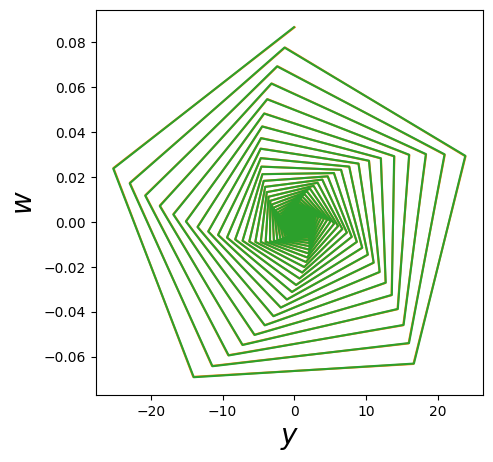

In [110]:
param_list=[w_L,beta_eq,r,eta]    
tf=1e-3               ### DO NOT increase this by a lot
u_0,v_0=2e-1,0
label_list=["$u$","$v$","$w$","$y$"]
N_step=500
fig, axs = plt.subplots(1, 1,figsize=(5,5))
theta_list=np.pi*np.linspace(0,1,3, endpoint=False)
#theta_list=np.pi*(1+1e-2*np.linspace(-1,1,2, endpoint=False))
#theta_list=np.pi*np.array([1])
for theta in theta_list:
    w_0=np.cos(theta)*1e-1
    y_0=np.sin(theta)*1e-1
    psi_0=np.array([u_0,v_0,w_0,y_0])
    zz,t=evolve(psi_0,tf,param_list,N_step)
  
    axs.plot(zz[2][:],zz[3][:])
    axs.set_ylabel("$w$",fontsize=20)
    axs.set_xlabel('$y$',fontsize=20)

plt.show() 

$\ddot{\varphi}+2(\eta-\frac{2}{\Omega}\frac{(1+r^2)(r+\varphi)}{[1+(r+\varphi)^2]^3})\dot{\varphi}+\frac{\varphi(\varphi+2r)}{1+(r+\varphi)^2}$

In [4]:
def ODE(t,z,ohm,r,eta,damp=1):
    phi,phi_d=z
    #phi_d_dot=1
    phi_d_dot=-2*damp*(eta-(2*(1+r**2)*(r+phi))/(ohm*(1+(r+phi)**2)**3))*phi_d-(phi*(phi+2*r))/(1+(r+phi)**2)
    phi_dot=phi_d
    return phi_dot,phi_d_dot
    
def evolve(psi_0,tf,param_list,N_step=100):
    t = np.linspace(0,tf,N_step)
    #xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t,method="RK23")
    xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t)
    zz=xx.sol(t)
    return zz,t

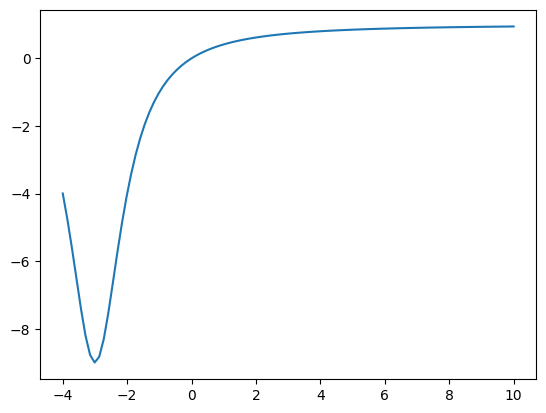

In [302]:
r=3
phi_0=np.linspace(-4,10,100)
E0=phi_0*(phi_0+2*r)/(1+(r+phi_0)**2)
plt.plot(phi_0,E0)
plt.show()

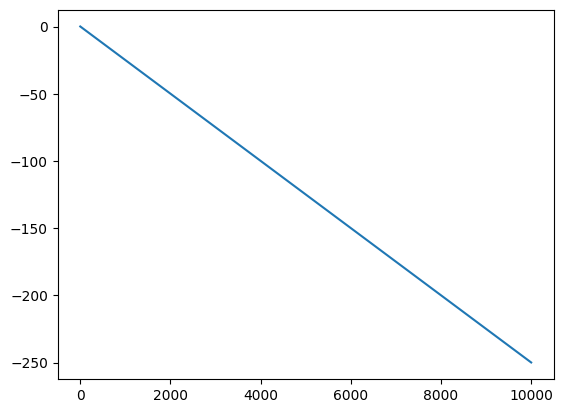

In [14]:
eta=20
phi_0=1e-3
t_list=10000*np.linspace(0,1,1000)
phi=((1-np.exp(-2*eta*t_list)/(2*eta)-t_list)/(2*eta))+phi_0
plt.plot(t_list,phi)
plt.show()

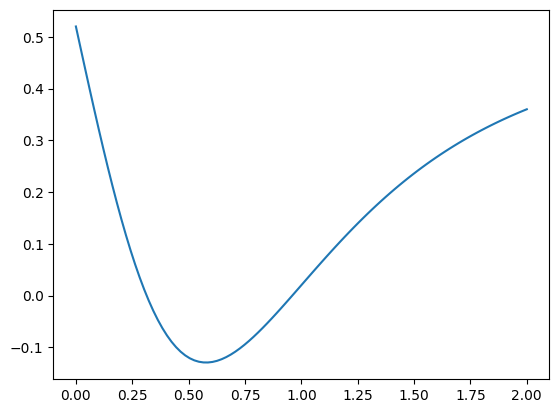

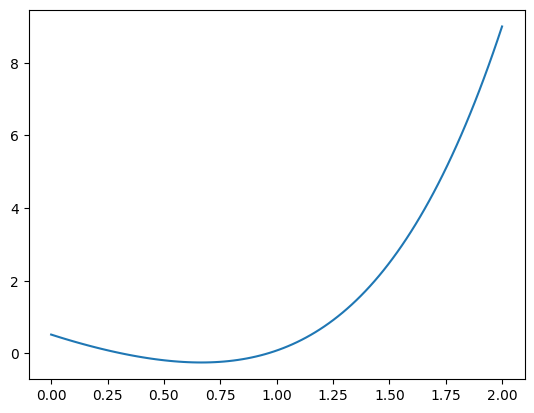

In [35]:
ohm=4
eta=0.13
r_list=np.linspace(0,2,100)
f=lambda r: (eta*ohm*(1+r**2)**2-2*r)/(1+r**2)**2
plt.plot(r_list,f(r_list))
plt.show()
f=lambda r: (eta*ohm*(1+r**2)**2-2*r)
plt.plot(r_list,f(r_list))
plt.show()

In [50]:
ohm=4
eta=0.13
eta_max=3**(1.5)/(ohm*8)


r_range=amplification_info(eta,ohm)

<IPython.core.display.Latex object>

[0.3137 0.9599]


-0.032379763209582246


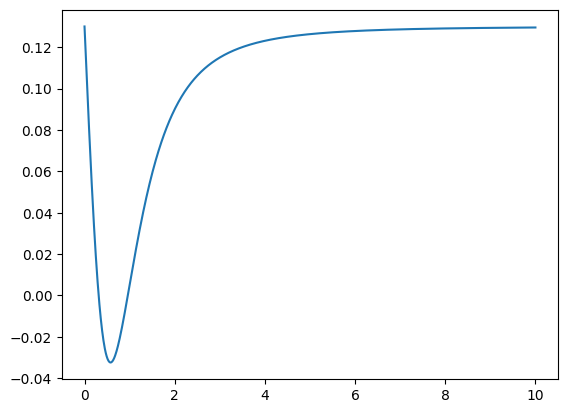

In [28]:
eta=0.13
ohm=4e0
r_list=np.linspace(0,10,1000)
def ret_gamma_0(r,eta,ohm):
    gamma_0=eta-2*r/(ohm*(1+r**2)**2)
    return gamma_0

def ret_gamm_0_d(r,eta,ohm):
    gamma_0_d=(2/ohm)*(1-3*r**2)/(1+r**2)**3
    return gamma_0_d
print(eta-3**1.5/(8*ohm))
plt.plot(r_list,ret_gamma_0(r_list,eta,ohm))
plt.show()

<IPython.core.display.Latex object>

r_range [0.4084 0.7876]
gamma_0 -0.005600987201818758


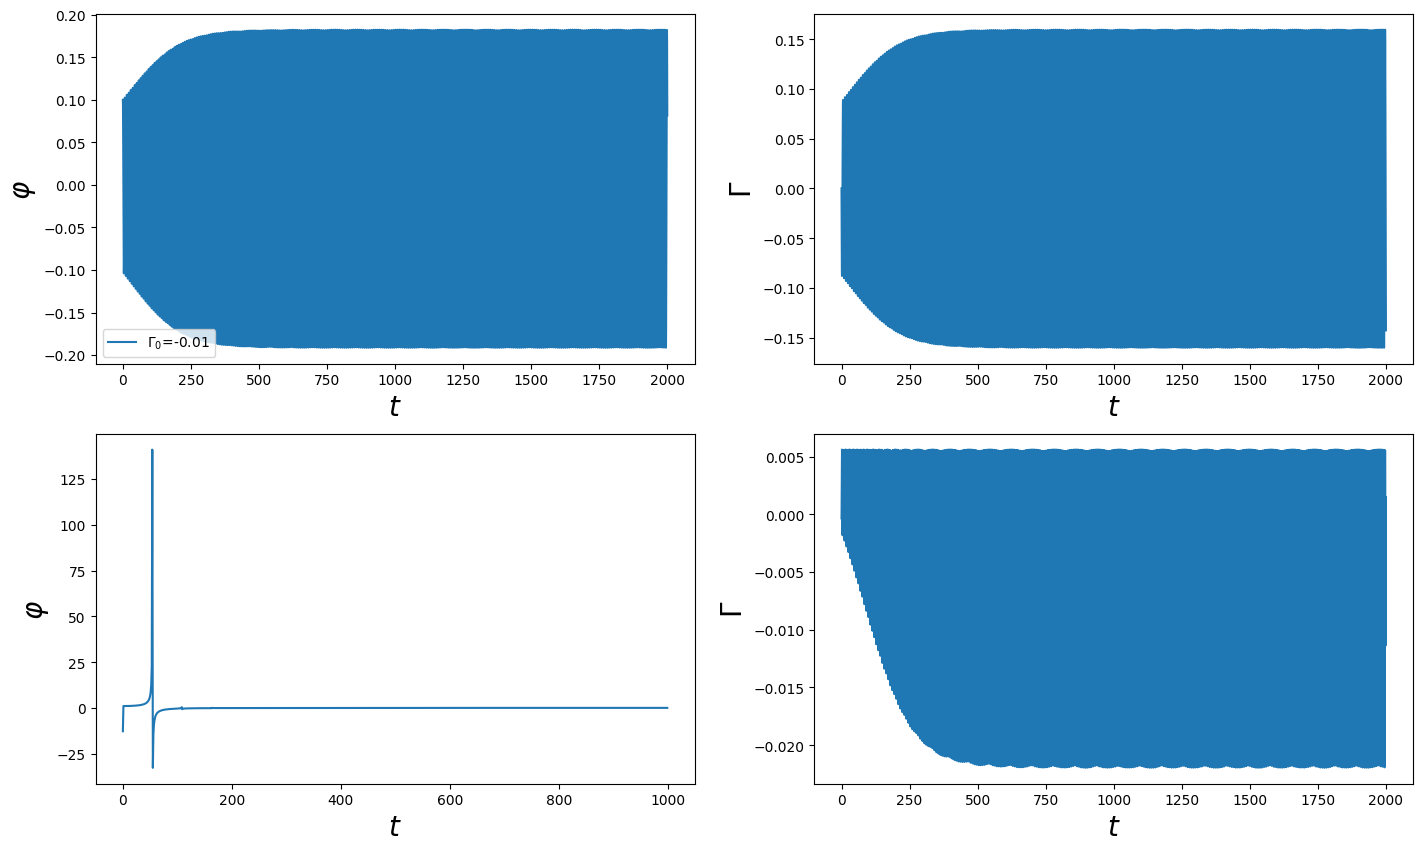

In [114]:
eta=0.15
ohm=4e0
r=0.45
r_range=amplification_info(eta,ohm)
print("r_range",r_range)
if r<r_range[0] or r>r_range[1]:
    print("r out of range, select r to be in amplification regime")
gamma_0=eta-2*r/(ohm*(1+r**2)**2)
print("gamma_0",gamma_0)
   
tf=2e3              ### DO NOT increase this by a lot
phi_0,phi_d_0=1e-1,0
E0=phi_0*(phi_0+2*r)/(1+(r+phi_0)**2)
#print(E0)
psi_0=np.array([phi_0,phi_d_0])

N_step=1000*10
param_list=[ohm,r,eta,1] 
zz,t=evolve(psi_0,tf,param_list,N_step)
fig, axs = plt.subplots(2, 2,figsize=(17,10))

axs[0,0].plot(t,zz[0],label="$\Gamma_0$={0}".format(np.round(gamma_0,2)))
# axs[0,0].set_ylim([-1e-3,1e-3])
axs[0,0].set_ylabel("$\\varphi$",fontsize=20)
axs[0,0].set_xlabel('$t$',fontsize=20)
#axs[0,0].set_xlim([1990,2000])
axs[0,0].legend(loc='best')
# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

# axs[0,1].plot(t,-(eta-(2*(1+r**2)*(r+zz))/(ohm*(1+(r+zz)**2)**3)))

axs[0,1].plot(t,zz[1])
axs[0,1].set_ylabel("$\Gamma$",fontsize=20)
axs[0,1].set_xlabel('$t$',fontsize=20)

# param_list=[ohm,r,eta,0] 
# zz1,t=evolve(psi_0,tf,param_list,N_step)

# axs[1,0].plot(t,zz[0])
f_range=[4*N_step//5,N_step]
#f_range=[N_step//2,N_step]

omega_list=np.arange((f_range[1]-f_range[0])//2)

axs[1,0].plot(omega_list,np.fft.fft(zz[0][f_range[0]:f_range[1]])[:(f_range[1]-f_range[0])//2])
# axs[1,0].set_xlim([100,200])
#axs[1,0].set_xlim([0,100])

axs[1,0].set_ylabel("$\\varphi$",fontsize=20)
axs[1,0].set_xlabel('$t$',fontsize=20)

# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

axs[1,1].plot(t,-(eta-(2*(1+r**2)*(r+zz[0]))/(ohm*(1+(r+zz[0])**2)**3)))
axs[1,1].set_ylabel("$\Gamma$",fontsize=20)
axs[1,1].set_xlabel('$t$',fontsize=20)

plt.show() 

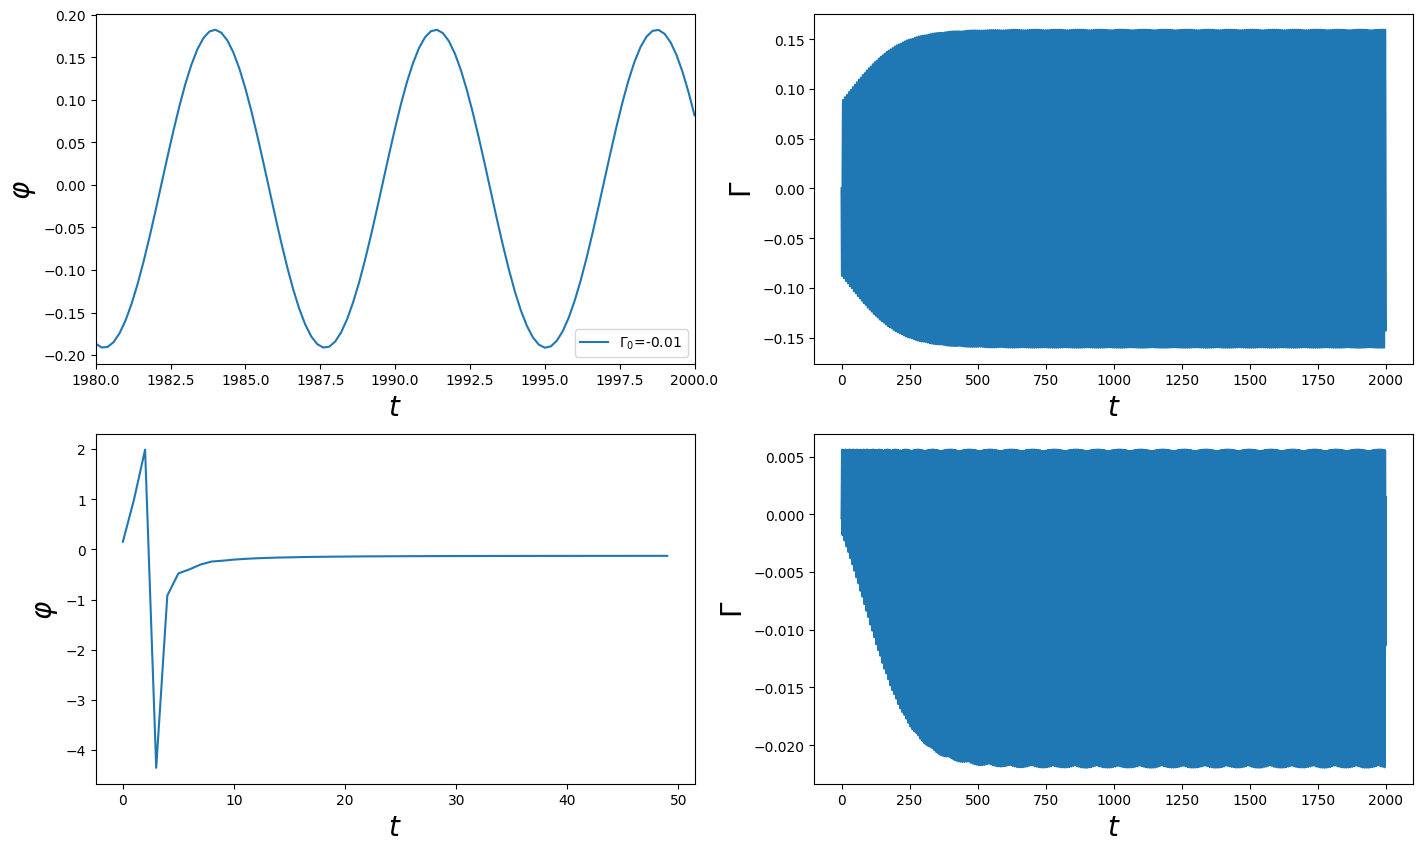

In [116]:
fig, axs = plt.subplots(2, 2,figsize=(17,10))
f_range=[int(0.99*N_step),N_step]

axs[0,0].plot(t,zz[0],label="$\Gamma_0$={0}".format(np.round(gamma_0,2)))
# axs[0,0].set_ylim([-1e-3,1e-3])
axs[0,0].set_ylabel("$\\varphi$",fontsize=20)
axs[0,0].set_xlabel('$t$',fontsize=20)
axs[0,0].set_xlim([int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)])
axs[0,0].legend(loc='best')
# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

# axs[0,1].plot(t,-(eta-(2*(1+r**2)*(r+zz))/(ohm*(1+(r+zz)**2)**3)))

axs[0,1].plot(t,zz[1])
axs[0,1].set_ylabel("$\Gamma$",fontsize=20)
axs[0,1].set_xlabel('$t$',fontsize=20)

# param_list=[ohm,r,eta,0] 
# zz1,t=evolve(psi_0,tf,param_list,N_step)

# axs[1,0].plot(t,zz[0])
#f_range=[N_step//2,N_step]

omega_list=np.arange((f_range[1]-f_range[0])//2)

axs[1,0].plot(omega_list,np.fft.fft(zz[0][f_range[0]:f_range[1]])[:(f_range[1]-f_range[0])//2])
# axs[1,0].set_xlim([100,200])
#axs[1,0].set_xlim([0,100])

axs[1,0].set_ylabel("$\\varphi$",fontsize=20)
axs[1,0].set_xlabel('$t$',fontsize=20)

# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

axs[1,1].plot(t,-(eta-(2*(1+r**2)*(r+zz[0]))/(ohm*(1+(r+zz[0])**2)**3)))
axs[1,1].set_ylabel("$\Gamma$",fontsize=20)
axs[1,1].set_xlabel('$t$',fontsize=20)

plt.show() 

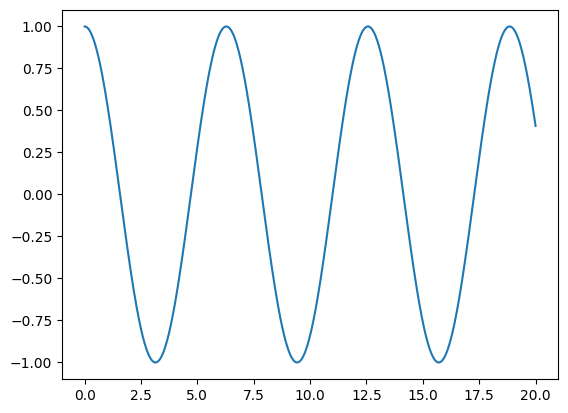

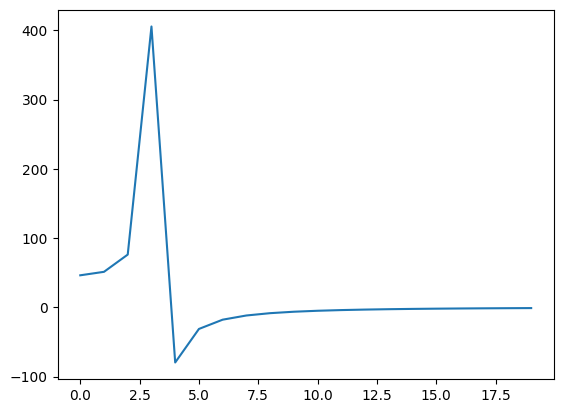

In [125]:
a=np.linspace(0,20,1000)
b=np.cos(a)
plt.plot(a,b)
plt.show()
plt.plot(np.fft.fft(b)[:20])
plt.show()

-0.010000000000000009


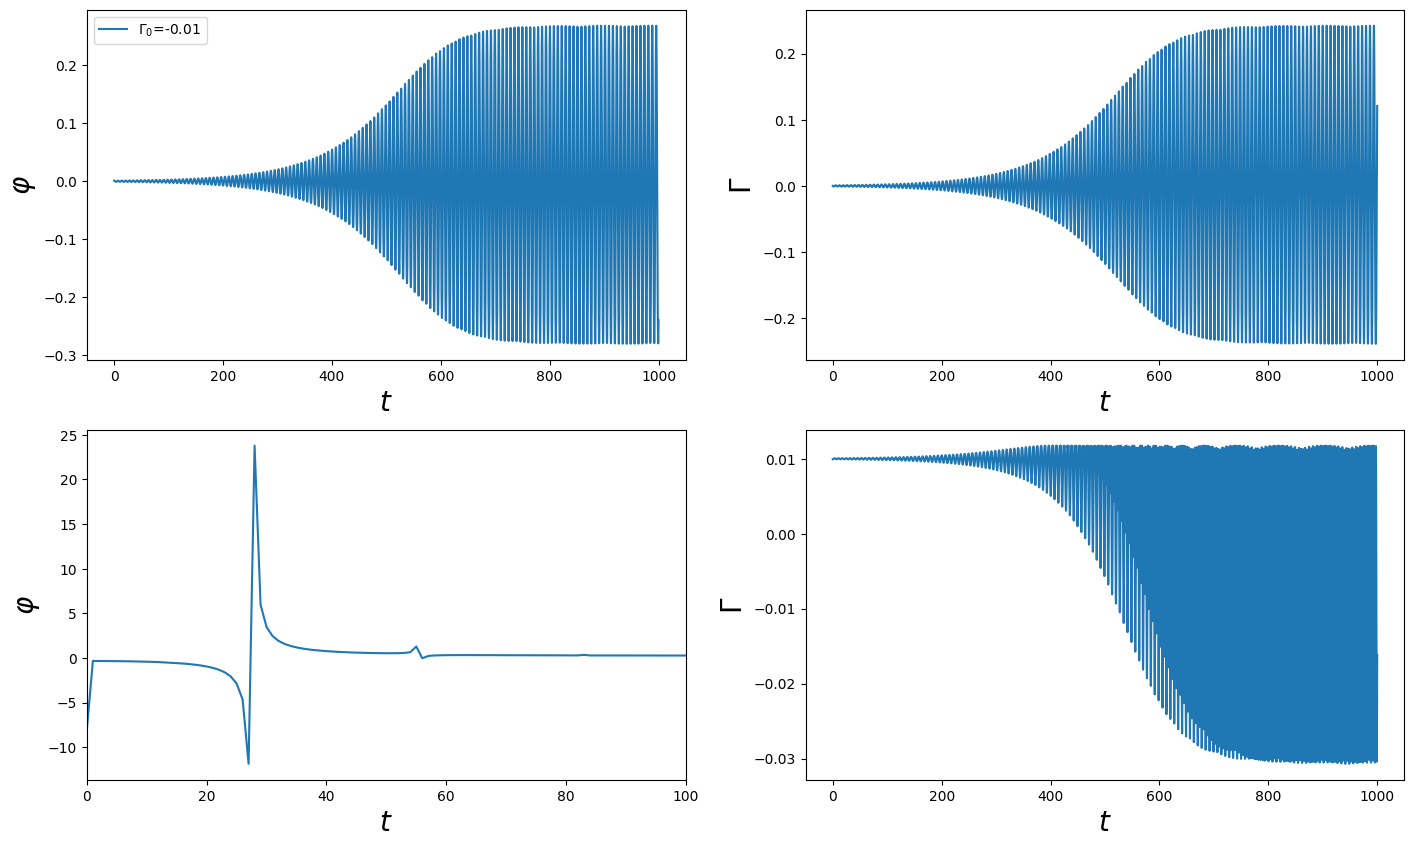

In [15]:
eta=0.15
ohm=4e0
r=0.5

gamma_0=eta-2*r/(ohm*(1+r**2)**2)
print(gamma_0)
   
tf=1e3              ### DO NOT increase this by a lot
phi_0,phi_d_0=1e-3,0
E0=phi_0*(phi_0+2*r)/(1+(r+phi_0)**2)
#print(E0)
psi_0=np.array([phi_0,phi_d_0])

N_step=1000*4
param_list=[ohm,r,eta,1] 
zz,t=evolve(psi_0,tf,param_list,N_step)
fig, axs = plt.subplots(2, 2,figsize=(17,10))

axs[0,0].plot(t,zz[0],label="$\Gamma_0$={0}".format(np.round(gamma_0,2)))
# axs[0,0].set_ylim([-1e-3,1e-3])
axs[0,0].set_ylabel("$\\varphi$",fontsize=20)
axs[0,0].set_xlabel('$t$',fontsize=20)
axs[0,0].legend(loc='best')
# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

# axs[0,1].plot(t,-(eta-(2*(1+r**2)*(r+zz))/(ohm*(1+(r+zz)**2)**3)))

axs[0,1].plot(t,zz[1])
axs[0,1].set_ylabel("$\Gamma$",fontsize=20)
axs[0,1].set_xlabel('$t$',fontsize=20)

param_list=[ohm,r,eta,0] 
zz1,t=evolve(psi_0,tf,param_list,N_step)

# axs[1,0].plot(t,zz[0])
f_range=[4*N_step//5,N_step]
omega_list=np.arange((f_range[1]-f_range[0])//2)

axs[1,0].plot(omega_list,np.fft.fft(zz[0][f_range[0]:f_range[1]])[:(f_range[1]-f_range[0])//2])
# axs[1,0].set_xlim([100,200])
axs[1,0].set_xlim([0,100])

axs[1,0].set_ylabel("$\\varphi$",fontsize=20)
axs[1,0].set_xlabel('$t$',fontsize=20)

# axs[1].plot(np.fft.fft(zz)[:N_step//2])
# axs[1].set_ylabel("$\\tilde{\\varphi}[\omega]$",fontsize=20)
# axs[1].set_xlabel('$\omega$',fontsize=20)

axs[1,1].plot(t,-(eta-(2*(1+r**2)*(r+zz[0]))/(ohm*(1+(r+zz[0])**2)**3)))
axs[1,1].set_ylabel("$\Gamma$",fontsize=20)
axs[1,1].set_xlabel('$t$',fontsize=20)

plt.show() 

In [2]:
np.arctan(3)

1.2490457723982544

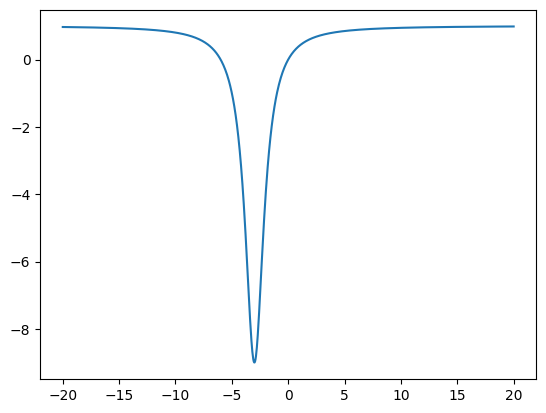

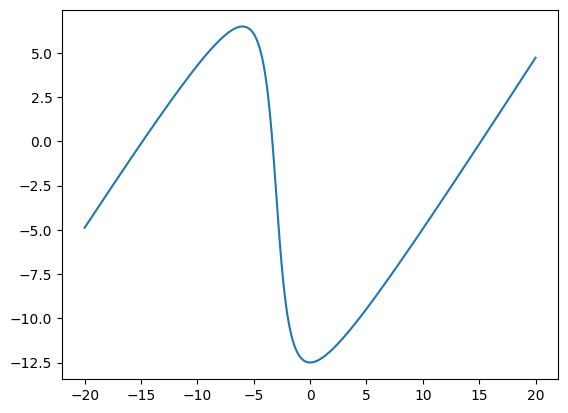

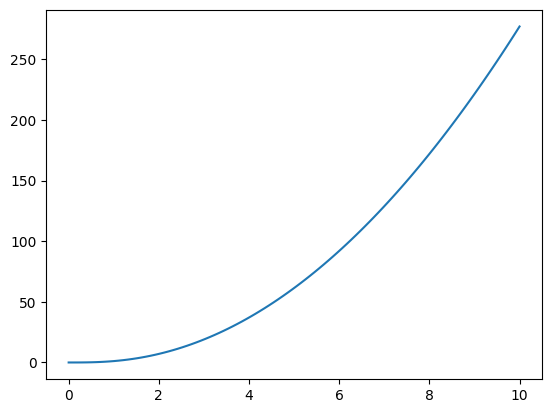

In [129]:
phi=np.linspace(-1,1,1000)*20
r=3
v_x=phi*(phi+2*r)/(1+(r+phi)**2)
plt.plot(phi,v_x)
plt.show()
#phi=np.linspace(-1,1,1000)*10

v=phi-(r**2+1)*np.arctan(r+phi)
plt.plot(phi,v)
plt.show()
r=np.linspace(0,10,100)
plt.plot(r,2*(r**2+1)*np.arctan(r)-2*r)
plt.show()

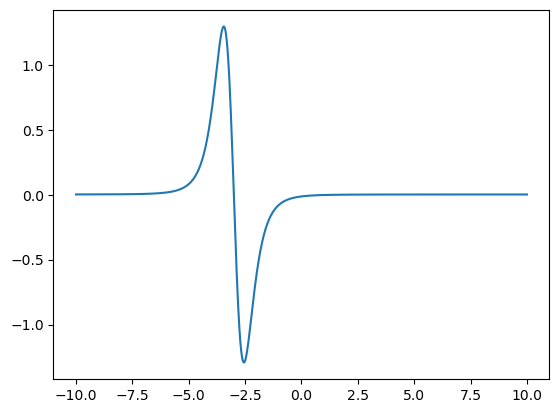

In [30]:
r=3
eta=2e-3
ohm=4e0

def damp_term(phi,r,eta,ohm):
    gamma=eta-2*(1+r**2)*(r+phi)/(ohm*(1+(r+phi)**2)**3)
    return gamma

phi=np.linspace(-10,10,1000)
gamma=damp_term(phi,r,eta,ohm)
plt.plot(phi,gamma)
# plt.ylim(-0.1,0.1)
plt.show()

In [21]:
def V1(phi,r,E):
    v=phi*(phi+2*r)/(1+(r+phi)**2)
    return v

def V0(phi,r,E):
    v=phi-(r**2+1)*np.arctan(r+phi)-E
    return v

def V2(phi,r,E):
    v=2*(phi+r)*(1+r**2)/(1+(r+phi)**2)**2
    return v

def ret_root(r,E):
    E_min=-(r**2+1)*np.arctan(r)
    E_max=(r**2+1)*np.arctan(r)-2*r
    Error_msg="Bro! pick the energy between the max {2}  and min {3},got :{0} for r:{1} ".format(E,r,E_max,E_min)
    assert E<E_max and E>E_min, Error_msg
    root=[]
    i=0
    while len(root)<2 and i<100:
        x0=(2*np.random.rand()-1)*2*r
        x = np.round(optimize.newton(V0, x0, fprime=V1,fprime2=V2,args=(r,E,)),4)
        if x>-2*r and x not in root:
            root.append(x)
        i+=1
    root=np.sort(root)
    return root

def calc_T(V0,r,E):
    roots=ret_root(r,E)
    if len(roots)==1:
        print("roots not found properply")
        return
    #print(roots)
    th=1e-4
    d=quad(lambda x,r,E : (-2*V0(x,r,E))**-0.5,roots[0]+th,roots[1]-th,args=(r,E))[0]
    return d

def damp_coeff(t,T,A,r=1):
    #x=-2*r
    x=0
    psi=x+A*np.cos(2*np.pi*t/T)
    y=((1+r**2)*(r+psi)/(1+(r+psi)**2)**3)
    return y/T

def amplification_info(eta,ohm):
    eta_max=3**(1.5)/(ohm*8)
    display(Latex("$\eta_{max}=$"+str(eta_max)))
    if eta>=eta_max:
        print("amplification not possible")
        return

    root=[]
    i=0
    while len(root)<2 and i<100:
        x0=(2*np.random.rand()-1)*1e-1+3**-0.5
        x = np.round(optimize.newton(lambda r: eta*ohm*(1+r**2)**2-2*r, x0, fprime=lambda r : eta*ohm*4*r*(1+r**2)-2),4)
        if x not in root:
            root.append(x)
        i+=1
    root=np.sort(root)
    return root


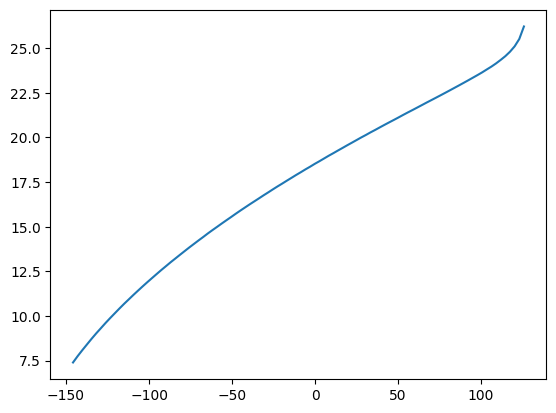

In [172]:
r=10
T=[]
E_list=np.linspace(-(r**2+1)*np.arctan(r),(r**2+1)*np.arctan(r)-2*r,100)[1:-1]
for E in E_list:    
    T.append(calc_T(V0,r,E))
plt.plot(E_list,T)
plt.show()

In [177]:
r=3
E=-10
for i in range(1):
    root=[]
    while len(root)<2:
        x0=(2*np.random.rand()-1)*2*r
        x = np.round(optimize.newton(V0, x0, fprime=V1,fprime2=V2,args=(r,E,)),8)
        if x>-2*r and x not in root:
            root.append(x)
    root=np.sort(root)
    print(root)

[-1.96263362  4.35699141]


In [40]:
import matplotlib as mpl

cmap = plt.cm.viridis  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[(cmap.N-1)//2] = (1., 1., 1., 1.0)
cmaplist[(cmap.N+1)//2] = (1., 1., 1., 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
# bounds = np.linspace(0, 20, 21)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

C:\Users\jhash\AppData\Local\Temp\ipykernel_164\2587837457.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.round(A_list[::20],1))


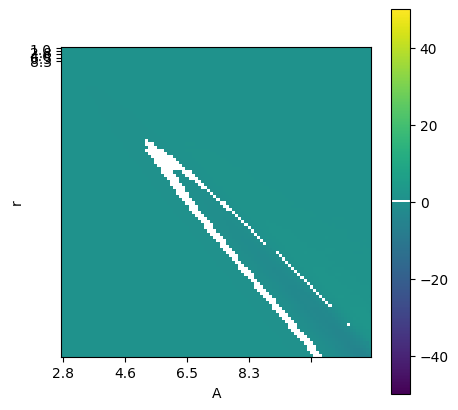

In [246]:
fig,ax=plt.subplots(figsize=(5,5))
ax.imshow(eta_eff,cmap=cmap,vmin=-50,vmax=50)
ax.set_xlabel("A")
#plt.xticks(np.round(A_list[::20],1))
#ax.set_xticks(np.arange(5))
ax.set_xticklabels(np.round(A_list[::20],1))

ax.set_ylabel("r")
ax.set_yticks(np.arange(5),labels=np.round(r_list[::20],1))
#ax.set_yticklabels(np.round(r_list[::20],1))
#ax.savefig("")

img=ax.imshow(eta_eff,cmap=cmap,vmin=-50,vmax=50)
plt.colorbar(img,ax=ax)
plt.show()

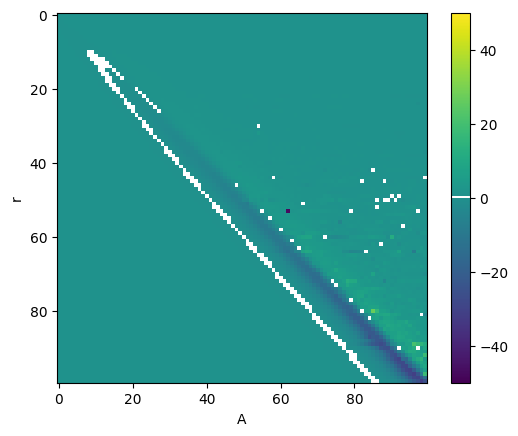

In [253]:
plt.imshow(eta_eff,cmap=cmap,vmin=-50,vmax=50)
plt.colorbar()
plt.xlabel("A")
#plt.xticks(A_list)
plt.ylabel("r")
#plt.yticks(r_list)
plt.savefig("C:/Users/jhash/Documents/renders/damping_E={0}_eta={1}_ohm={2}.jpg".format(E,eta,ohm))
plt.show()

C:\Users\jhash\AppData\Local\Temp\ipykernel_14208\2636037532.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r))[0]/(eta*ohm)
C:\Users\jhash\AppData\Local\Temp\ipykernel_14208\2636037532.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r))[0]/(eta*ohm)
C:\Users\jhash\AppData\Local\Temp\ipykernel_14208\2636037532.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it

roots not found properply


C:\Users\jhash\AppData\Local\Temp\ipykernel_14208\2636037532.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r))[0]/(eta*ohm)
C:\Users\jhash\AppData\Local\Temp\ipykernel_14208\2636037532.py:15: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r))[0]/(eta*ohm)
C:\Users\jhash\AppData\Local\Temp\ipykernel_14208\2636037532.py:15: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r)

roots not found properply
roots not found properply


KeyboardInterrupt: 

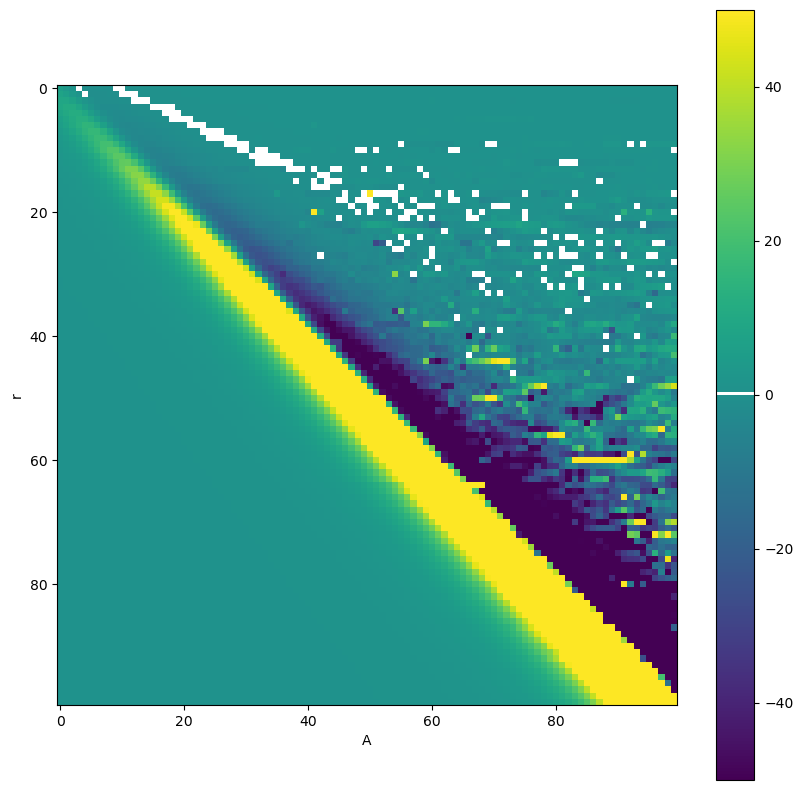

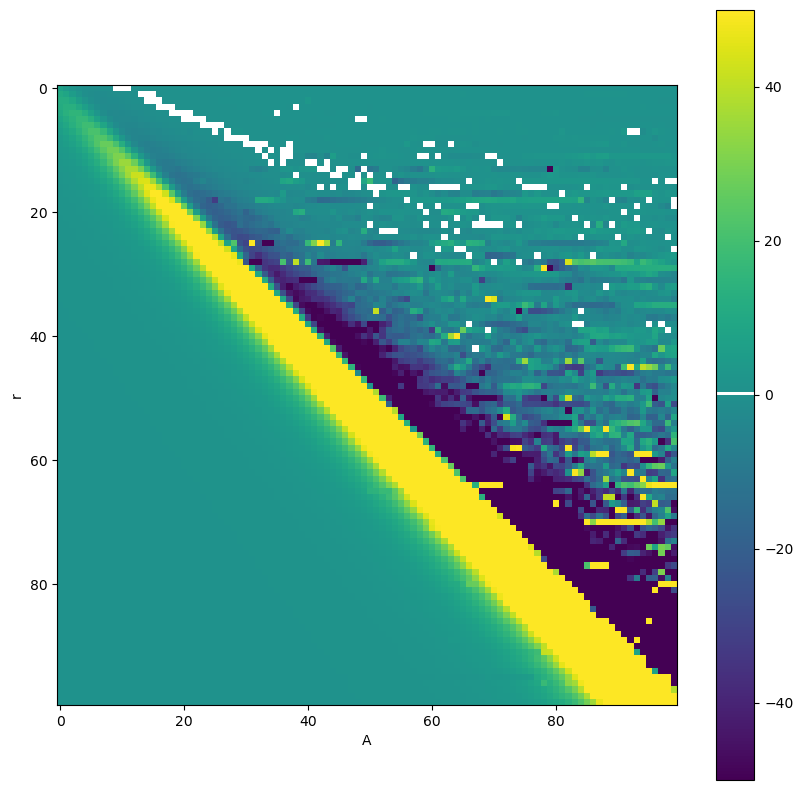

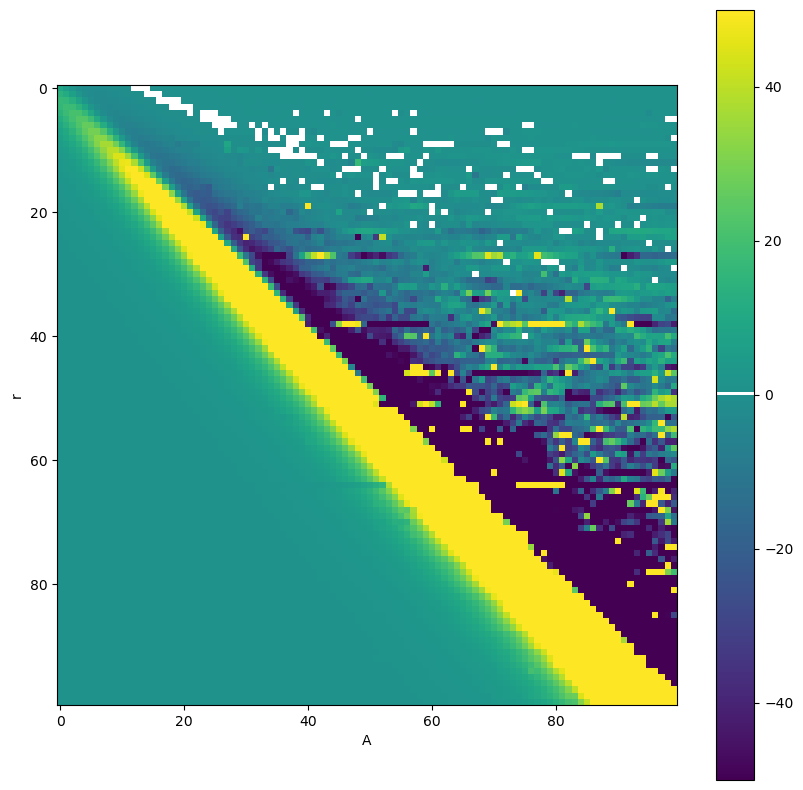

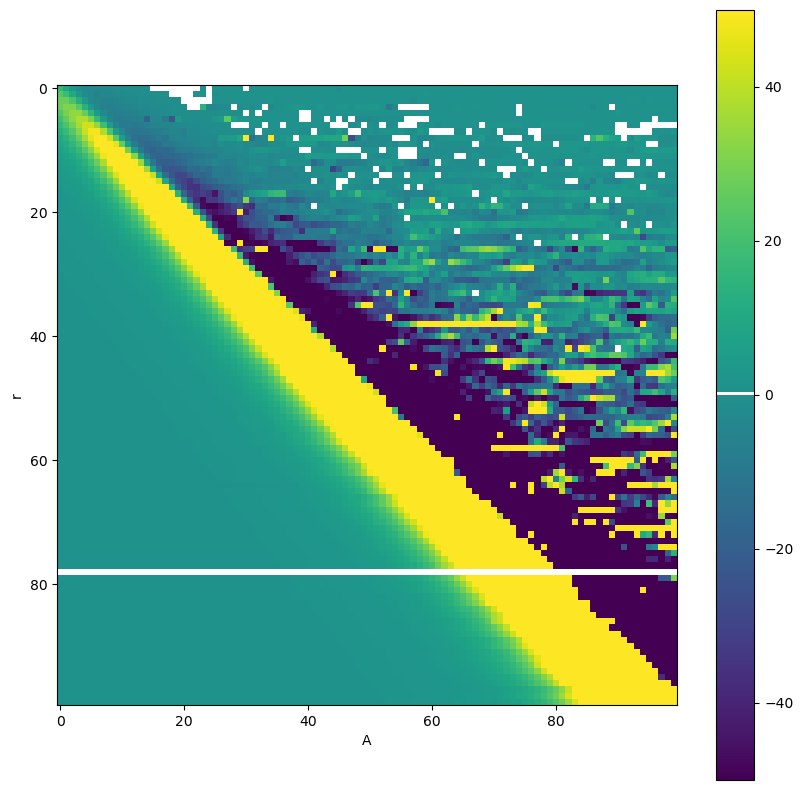

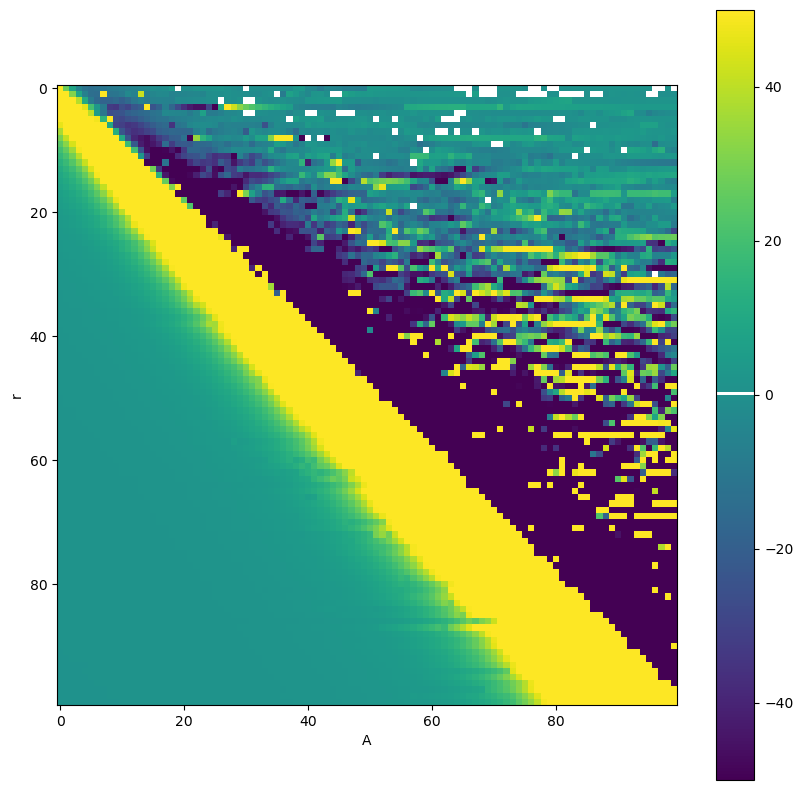

In [38]:
N_g=100
E=-1
eta=0.15
ohm=4e0
E_list=np.linspace(-1,1,10)
folder="C:/Users/jhash/OneDrive - City University of New York/Opto/Simulation/plots/"
for E in E_list:
    r_list=20*np.linspace(0.1,1,N_g)
    A_list=20*np.linspace(0.1,1,N_g)
    eta_eff=np.zeros((N_g,N_g))
    for i, r in enumerate(r_list):
        T=calc_T(V0,r,E)
        if T:
            for j,A in enumerate(A_list):
                eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(E,A,r))[0]/(eta*ohm)

    # plt.imshow(eta_eff,cmap='seismic')
    # plt.colorbar()
    # plt.show()
    if np.trace(eta_eff)>0:
        plt.figure(figsize=(10,10))
        plt.imshow(eta_eff,cmap=cmap,vmin=-50,vmax=50)
        plt.colorbar()
        plt.xlabel("A")
        #plt.xticks(A_list)
        plt.ylabel("r")
        #plt.yticks(r_list)
        file="damping_E={0}_eta={1}_ohm={2}.jpg".format(np.round(E,2),eta,ohm)
        #plt.savefig("C:/Users/jhash/Documents/renders/damping_E={0}_eta={1}_ohm={2}.jpg".format(E,eta,ohm))
        plt.savefig(folder+file)
        #plt.show()

C:\Users\jhash\AppData\Local\Temp\ipykernel_13400\1019685282.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]/(eta*ohm*np.pi)
C:\Users\jhash\AppData\Local\Temp\ipykernel_13400\1019685282.py:10: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]/(eta*ohm*np.pi)


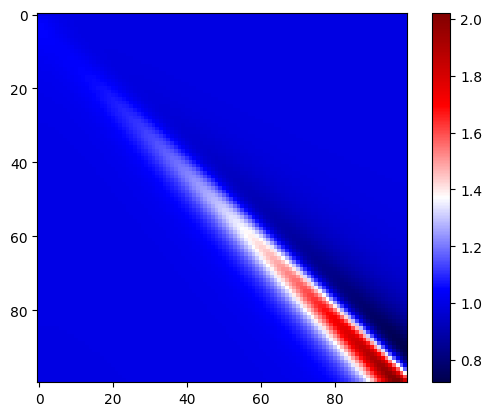

In [41]:
N_g=100
#omega=1

r_list=10*np.linspace(0,1,N_g)
A_list=10*np.linspace(0,1,N_g)
eta_eff=np.zeros((N_g,N_g))
for i, r in enumerate(r_list):
    for j,A in enumerate(A_list):
        omega=(r/(1+r**2))**0.5
        T=2*np.pi/omega
        eta_eff[i,j]=1-2*quad(damp_coeff,0,T,args=(A,r))[0]/(eta*ohm*T)
        
plt.imshow(eta_eff,cmap='seismic')
plt.colorbar()
plt.show()

C:\Users\jhash\AppData\Local\Temp\ipykernel_13400\2994802689.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]
C:\Users\jhash\AppData\Local\Temp\ipykernel_13400\2994802689.py:8: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]


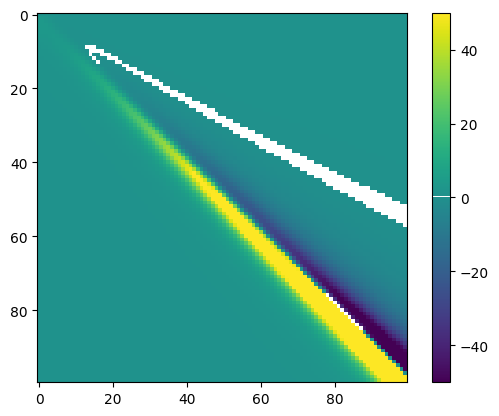

In [48]:
N_g=100
r_list=20*np.linspace(0,1,N_g)
A_list=20*np.linspace(0,1,N_g)
eta_eff=np.zeros((N_g,N_g))
for i, r in enumerate(r_list):
    for j,A in enumerate(A_list):
        omega=(r/(1+r**2))**0.5
        eta_eff[i,j]=1-quad(damp_coeff,0,2*np.pi/omega,args=(A,r))[0]
        
plt.imshow(eta_eff,cmap=cmap,vmin=-50,vmax=50)
plt.colorbar()
plt.show()

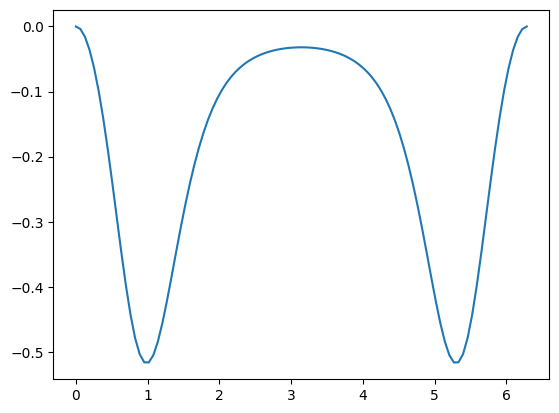

In [69]:
x=np.linspace(0,2*np.pi,100)
y=damp_coeff(x,1,1)
plt.plot(x,y)